# **DistilBert for movie spoiler text classification**
<br>

## **References:-**

[1] DistilBERT base model (uncased)  https://huggingface.co/distilbert-base-uncased <br>

[2] DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter https://arxiv.org/abs/1910.01108

## **Dataset**

[IMDB Spoiler Dataset](https://www.kaggle.com/datasets/rmisra/imdb-spoiler-dataset).

The description provided on Kaggle:

*This dataset is collected from IMDB. It contains meta-data about items as well as user reviews with information regarding whether a review contains a spoiler or not.*

### In this notebook we are experimenting on the results of DistillBERT model on dataset with extra processed and 25% unsampled of the original data 

Importing the various standard library like sklearn, pandas, numpy, os, shutil

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [ ]:
import os
import shutil

This below code imports several libraries for natural language processing (NLP) and data visualization tasks.
  * The **'transformers'** library is imported to use pre-trained models and tokenizers for NLP tasks. 
  * We import **'AutoTokenizer'** and **'TFAutoModelForSequenceClassification'** from **'transformers'** to tokenize text data and load a pre-trained model for sequence classification.
  * The **'json'** library is imported to work with JSON data, allowing us to read and write JSON files. 
  * The **'matplotlib.pyplot'** library is imported as **'plt'** to create visualizations, such as plots and charts. 
  * The **'random'** library is imported to generate random numbers or randomly shuffle data. 
  * The **'seaborn'** library is imported as 'sn' to enhance the visual appeal of plots created with 'matplotlib'. 
  * The **'tensorflow'** library is imported as 'tf' for building and training machine learning models, particularly in the context of deep learning. 
  
  By importing these libraries, we ensure that we have access to the necessary functions and tools for our NLP and data visualization tasks.


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.4 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import json
import matplotlib.pyplot as plt
import random
import seaborn as sn
import tensorflow as tf

We need to load the processed data and hence we are mounting Google Drive in the notebook. Then we are loading the data which is **extra processed and 25% unsampled from the original data**. Next we are adding some shuffling to the data.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
# /content/drive/MyDrive/cleaned_data.csv
data = pd.read_json("drive/MyDrive/extra_processed.json")
data = data.sample(int(0.25*len(data)))

Mounted at /content/drive


The **AutoTokenizer** class from the **Hugging Face** library is used to create a tokenizer. Specifically, the **distilbert-base-uncased** model is used as a pretrained tokenizer.

By calling AutoTokenizer.from_pretrained("distilbert-base-uncased"), the tokenizer is initialized with the pretrained model. This tokenizer is capable of transforming text inputs into numerical representations that can be processed by machine learning models.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased") #Tokenizer

In [ ]:
texts = list(data["review_text"])

In [ ]:
texts

['oddball comedy featuring an eccentric assortment of folks who keep popping up at weddings each looking for a mate hugh grant as usual was delightful and the rest of the cast were excellent a funny offbeat and well done film',
 'this movie is 10 lots of spirit in the moviei can watch thus movie as many times as to eat lots of love lots of emotion and the movie up to your expectations i know plots some what expected but dont we want that the movie want us to feel happy now a days all the stories are repeated but the direction comes at this situation and we lots of good direction in it director did a great job rating this movie feels good suggestion if you want to see a good movie after a long time then this is the movie you are looking forward to this movie got lot of heart into it and makes us know the place of the family in our lifes and the missing spark and happiness of lonely guy',
 'the bourne ultimatum is easily one of the greatest cinematic masterpieces of all time the action t

We then use the tokenizer on the imported dataset and store the tokenized data as tensor

In [ ]:
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='tf') #Tokenized text

We are converting labels with True or False output to 1 or 0 output which can be used easily for processing

In [ ]:
labels = list(data["is_spoiler"])
categories=sorted(list(set(labels))) #set will return the unique different entries
n_categories=len(categories)

def indicize_labels(labels):
    """Transforms string labels into indices"""
    indices=[]
    for j in range(len(labels)):
        for i in range(n_categories):
            if labels[j]==categories[i]:
                indices.append(i)
    return indices

In [ ]:
batch_size=16

In [ ]:
indices = indicize_labels(labels)

We are creating TensorFlow dataset from the inputs and indices. We are spliting it into **30% validation** and **70% training** subsets, and applies batching with **batch size 16** and prefetching to the training subset.




In [ ]:
dataset=tf.data.Dataset.from_tensor_slices((dict(inputs), indices)) #Create a tensorflow dataset
#train test split, we use 10% of the data for validation
val_data_size=int(0.3*len(indices))
val_ds=dataset.take(val_data_size).batch(batch_size, drop_remainder=True) 
train_ds=dataset.skip(val_data_size).batch(batch_size, drop_remainder=True)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

We are initializing a model for sequence classification using the pretrained **"distilbert-base-uncased"** architecture.


---


DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

We are using **BinaryCrossEntropy** as a loss measure and **BinaryAccuracy** as an accuracy measure



In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

We are setting up a model checkpoint callback in TensorFlow, which saves the best model during training based on the validation binary accuracy. The checkpoint file will be saved at the specified checkpoint_filepath, and only the best model will be saved (save_best_only=True) based on the monitored metric.

In [ ]:
checkpoint_filepath = '/drive/MyDrive/checkpoint-distilbert-25%'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True)

The model is compiled using the Adam optimizer with a learning rate of 1e-5 and gradient clipping applied along with BinaryCrossentropy loss and BinaryAccuracy metric

We are then training the model for 3 epochs with the training and validation dataset defined above

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.), loss=loss, metrics=metrics)

In [ ]:
history=model.fit(train_ds, validation_data=val_ds, epochs=3, verbose=1 , callbacks=[model_checkpoint_callback])

Epoch 1/3
6277/6277 [==============================] - ETA: 0s - loss: 0.4817 - binary_accuracy: 0.7691

6277/6277 [==============================] - 937s 145ms/step - loss: 0.4817 - binary_accuracy: 0.7691 - val_loss: 0.4635 - val_binary_accuracy: 0.7815
Epoch 2/3
6277/6277 [==============================] - ETA: 0s - loss: 0.4387 - binary_accuracy: 0.7964

6277/6277 [==============================] - 760s 121ms/step - loss: 0.4387 - binary_accuracy: 0.7964 - val_loss: 0.4696 - val_binary_accuracy: 0.7876
Epoch 3/3
6277/6277 [==============================] - 741s 118ms/step - loss: 0.3868 - binary_accuracy: 0.8299 - val_loss: 0.5088 - val_binary_accuracy: 0.7849


We are saving this model to local drive to load this model after traning on the dataset

In [ ]:
model.save("drive/MyDrive/Distillbert_extra_25.tf")

We are predicting the validation data with our best model in the epochs

In [ ]:
# Load best checkpoint

reloaded_model = tf.keras.models.load_model("/drive/MyDrive/checkpoint-distilbert-25%")

In [ ]:
text = "This is an example sentence."
encoded_input = tokenizer(text, return_tensors='tf')
input_ids = encoded_input['input_ids']
attention_mask = encoded_input['attention_mask']

# Obtain the predicted probabilities for each class
outputs = model(input_ids, attention_mask=attention_mask)
predicted_probabilities = tf.nn.softmax(outputs.logits)

In [ ]:
print(predicted_probabilities)

tf.Tensor([[1.]], shape=(1, 1), dtype=float32)


In [ ]:
test_data = dataset.take(val_data_size-int(val_data_size % batch_size))

##Classification report

We are predicting the validation data with our best model in the epochs

In [ ]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
# Predict labels for test data
y_pred = model.predict(test_data)

43040/43040 [==============================] - 197s 5ms/step


In [ ]:
y_pred = tf.sigmoid(y_pred.logits)
y_pred = np.round(y_pred.numpy())
le = LabelEncoder()
test_labels = np.concatenate([y for x, y in val_ds], axis=0)
report = classification_report(test_labels, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.81      0.92      0.86     31740
           1       0.64      0.40      0.49     11300

    accuracy                           0.78     43040
   macro avg       0.72      0.66      0.67     43040
weighted avg       0.76      0.78      0.76     43040



##Plot of model accuracy vs epochs




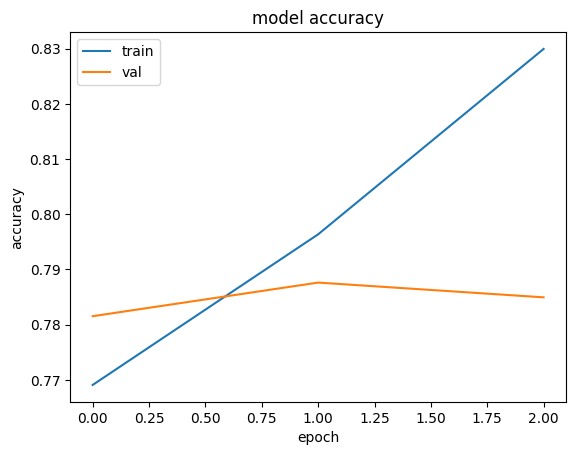

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##Plot of model loss vs epochs




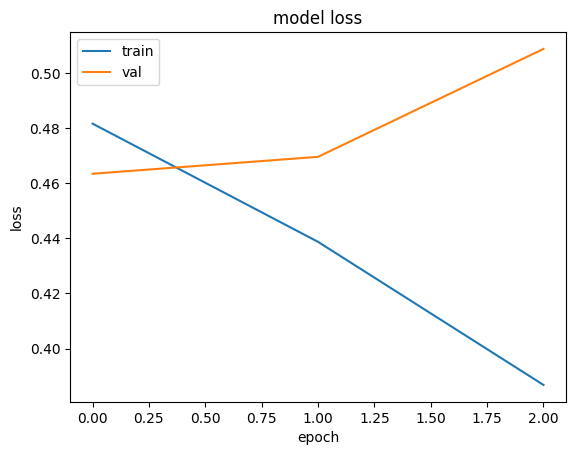

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Confusion matrix


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, y_pred)

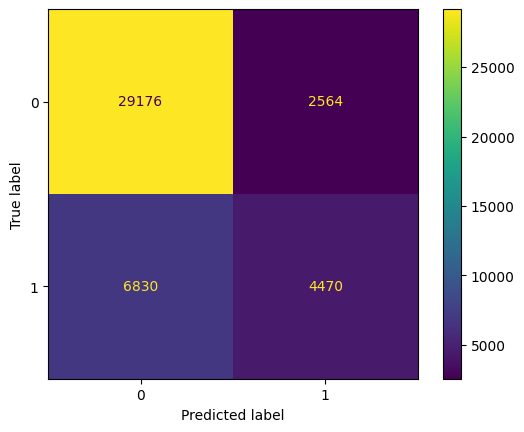

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()